In [1]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd
from torch.utils.data import Dataset, DataLoader
#import data_layer_cross 
import statistics
import seaborn as sns
import tensorflow as tf

/Users/elvisyan/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [33]:
#read input data 
datapath = "CharAll_na_rm_huge_train_variableall4_sentiment_full_new.npz"
data = np.load(datapath)
data, data['data'].shape, data['variable']

(NpzFile 'CharAll_na_rm_huge_train_variableall4_sentiment_full_new.npz' with keys: date, variable, wficn, data,
 (469, 3271, 61),
 array(['FC2Y', 'Beta', 'OA', 'CF', 'Variance', 'BEME', 'CTO', 'RNA', 'NI',
        'r12_2', 'CF2P', 'r36_13', 'ROA', 'r2_1', 'Resid_Var', 'DPI2A',
        'IdioVol', 'AC', 'PM', 'ATO', 'D2A', 'SUV', 'SGA2S', 'r12_7',
        'PCM', 'LT_Rev', 'D2P', 'Rel2High', 'LTurnover', 'ROE', 'MktBeta',
        'Investment', 'Lev', 'LME', 'E2P', 'ST_Rev', 'Spread', 'Q', 'A2ME',
        'NOA', 'C', 'OP', 'S2P', 'OL', 'AT', 'PROF', 'ages', 'flow',
        'exp_ratio', 'tna', 'turnover', 'Family_TNA', 'fund_no',
        'Family_r12_2', 'Family_flow', 'Family_age', 'F_ST_Rev', 'F_r2_1',
        'F_r12_2', 'sentiment'], dtype='<U12'))

In [3]:
#calculate mean for the macro-vairbale
sentiment = data['data'][:,:,-1]
sentiment_list = sentiment.flatten()
sentiment_mean = np.mean(sentiment_list)
sentiment_mean
def replace_outliers(array, upper, lower, replace=0):
    # Create a mask for values that are less than lower or greater than upper
    #by default replace with 0 
    mask = (array < lower) | (array > upper)
    array[mask] = replace
    return array
def split_list_chronological(data, ratio):
    '''given data(list), return two sublists by ratio, chronologically'''
    split_index = int(len(data) * ratio)
    part1 = data[:split_index]
    part2 = data[split_index:]
    return part1, part2
def sanitize_input_3d(input_features, mean=0, mean_macro=sentiment_mean):
    #expected input: [time, funds, variables]
    other_features = input_features[:,:, :-1]
    macro_features = input_features[:,:, -1:]
    other_features = replace_outliers(other_features, 0.5, -0.5, mean)
    macro_features= replace_outliers(macro_features, 90, -90, mean_macro)
    features_sanitized = np.concatenate((other_features, macro_features), axis=2)
    return features_sanitized
def get_mean_elementwise(tensor_list):
    stacked_tensors = torch.stack(tensor_list)
    mean_tensor = torch.mean(stacked_tensors, dim=0)
    return mean_tensor

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class SimpleDenseModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleDenseModel, self).__init__()
        self.dense1 = nn.Linear(input_size, hidden_size)
        self.dense2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = torch.relu(self.dense1(x))
        x = self.dense2(x)
        return x
def replace_outliers(array, upper, lower, replace=0):
    # Create a mask for values that are less than lower or greater than upper
    #by default replace with 0 
    mask = (array < lower) | (array > upper)
    array[mask] = replace
    return array
def get_valid_label_mask(dataset,lower, upper):
    labels = dataset[:, :, 0]
    valid_rows= (labels >= lower) & (labels <= upper)
    return valid_rows
def skip_labels(dataset, lower=-1, upper=1):
    #input should be the entire dataset 
    #skip the rows where there is no label 
    valid_rows = get_valid_label_mask(dataset, lower, upper)
    filtered_data = dataset[valid_rows]
    #print(filtered_data.shape)
    return filtered_data #this is of shape [time*funds, variables]
def sanitize_input(input_features, mean=0, mean_macro=sentiment_mean):
    #replace missing values in input with mean 
    #for macro variables, using mean_macro
    #expected input of shape [time*funds, variables] (2d)
    other_features = input_features[:,:-1]
    macro_features = input_features[:,-1:] #the last variable is the macro varibale
    other_features = replace_outliers(other_features, 0.5, -0.5, mean)
    macro_features= replace_outliers(macro_features, 90, -90, mean_macro)
    #print(other_features.shape, macro_features.shape)
    features_sanitized = np.concatenate((other_features, macro_features), axis=1)
    #print(features_sanitized.shape)
    return features_sanitized
def sanitize_input_3d(input_features, mean=0, mean_macro=sentiment_mean):
    #expected input: [time, funds, variables]
    other_features = input_features[:,:, :-1]
    macro_features = input_features[:,:, -1:]
    other_features = replace_outliers(other_features, 0.5, -0.5, mean)
    macro_features= replace_outliers(macro_features, 90, -90, mean_macro)
    features_sanitized = np.concatenate((other_features, macro_features), axis=2)
    return features_sanitized
def drop_input_based_on_r122(dataset):
    #drop row where r122 is 0 
    #input shape: [time*funds, variables]
    r122= dataset[:,10]
    mask = (r122 != 0)
    print(mask.shape)
    filtered_dataset = dataset[mask]
    return filtered_dataset
def get_valid_label_mask_month(labels,lower=-1, upper=1):
    #[funds,]
    valid_rows= (labels >= lower) & (labels <= upper)
    return valid_rows
def load_tf_weights_to_pytorch(checkpoint_path, input_size, hidden_size, output_size):
    # Use compatibility mode to access TensorFlow 1.x functionality
    tf.compat.v1.disable_eager_execution()

    # Create a NewCheckpointReader to read the TensorFlow checkpoint
    reader = tf.compat.v1.train.NewCheckpointReader(checkpoint_path)

    # Extract weights and biases from the checkpoint
    dense1_weights = reader.get_tensor('Model_Layer/NN_Layer/dense_layer_0/dense/kernel')
    dense1_bias = reader.get_tensor('Model_Layer/NN_Layer/dense_layer_0/dense/bias')
    dense2_weights = reader.get_tensor('Model_Layer/NN_Layer/last_dense_layer/dense/kernel')
    dense2_bias = reader.get_tensor('Model_Layer/NN_Layer/last_dense_layer/dense/bias')

    # Construct the PyTorch model with similar architecture
    model = SimpleDenseModel(input_size, hidden_size, output_size)
    
    # Load the weights and biases into the PyTorch model
    with torch.no_grad():
        model.dense1.weight = nn.Parameter(torch.tensor(dense1_weights.T))
        model.dense1.bias = nn.Parameter(torch.tensor(dense1_bias))
        model.dense2.weight = nn.Parameter(torch.tensor(dense2_weights.T))
        model.dense2.bias = nn.Parameter(torch.tensor(dense2_bias))

    return model
def checkdb(dataset, dataloader):
    sample_features, sample_labels = dataset[0]
    print("Features shape:", sample_features.shape)
    print("Labels shape:", sample_labels.shape)
    print('sample inputs:', sample_features, sample_labels)
    data_iter = iter(dataloader)
    batch_features, batch_labels = next(data_iter) 
    print("loader Features shape:", batch_features.shape)
    print("loader Labels shape:", batch_labels.shape)
def train_model(model, num_epochs, dataloader_train, dataloader_val, device=device, criterion = nn.MSELoss(), learning_rate=0.0025, early_stop=True, reg=1e-3, graph=False):
    '''train model with specified datasets'''
    print('training start')
    print('----------------------')
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_loss_avg = [] #average loss over all epochs 
    validation_loss_avg =[] 
    train_loss_std = [] #std of losses over all epochs
    validation_loss_std = []
    lossV= float('inf')
    stop = False
    for epoch in range(num_epochs):
        train_loss = [] #inividual loss for a single epoch
        validation_loss = []
        model.train() 
        running_loss = 0.0
        for inputs, labels in dataloader_train:
            inputs, labels = inputs.to(device), labels.to(device).float()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            l2_reg = torch.tensor(0.)
            for param in model.parameters():
                l2_reg = l2_reg + torch.norm(param, 2)
            loss = loss + reg * l2_reg
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            running_loss += loss.item()
        lossT = running_loss/len(dataloader_train)
        train_loss_avg.append(lossT)
        #train_loss_std.append(statistics.stdev(train_loss))
        #validation
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in dataloader_val:
                inputs, labels = inputs.to(device), labels.to(device).float()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                l2_reg = torch.tensor(0.)
                for param in model.parameters():
                    l2_reg = l2_reg + torch.norm(param, 2)
                loss = loss + reg * l2_reg
                validation_loss.append(loss.item())
                running_val_loss += loss.item()
        if (running_val_loss / len(dataloader_val)>=lossV):
            stop=True
        lossV = running_val_loss / len(dataloader_val)
        validation_loss_avg.append(lossV)
        #validation_loss_std.append(statistics.stdev(validation_loss))
        print(f"Epoch {epoch + 1}/{num_epochs}, Traning Loss: {lossT}, Validation loss: {lossV}")
        if stop and early_stop:
            print('validation stopped converging')
            break 
    return (train_loss_avg, validation_loss_avg, train_loss_std, validation_loss_std)
def predict(model, inputs):
    #predict at all timestep using model. inputs --> [time, funds, X]
    #return shape [time, funds, 1]
    input_features =torch.tensor(sanitize_input(inputs), dtype=torch.float32)#replace 
    model.eval()
    with torch.no_grad():
        outputs = model(input_features)
    #np.savetxt('sample.txt', outputs[:, :, -1], fmt='%s')
    #np.savetxt('inputsample.txt', input_features[0,:,:])
    return outputs
#pytorch dataset to help load input data
class DS(Dataset):
    '''constrcuct datast with input data(the dataset) and index list'''
    def __init__(self, data, idx_list, subset=None, indexes= range(47,61)):
        #data --> the unprocessed input
        #index list: the selected indexes
        self.indexes = [0]+list(indexes)
        if subset:
            column_considered = [0] + [x + 1 for x in subset] #keep the first column(label)
            all_data = drop_input_based_on_r122(skip_labels(self.filter_data_by_indices(data['data'][:, :, column_considered], idx_list)))
            self.all_data=all_data[:,self.indexes]
        else:
            all_data = drop_input_based_on_r122(skip_labels(self.filter_data_by_indices(data['data'],idx_list)))
            self.all_data = all_data[:,self.indexes]
        labels = np.expand_dims(self.all_data[:, 0]*100, axis=1) #the first column contains the labels 
        print("labels shape",labels.shape)
        features = self.all_data[:, 1:] #the others are the input features
        features = sanitize_input(features)
        print("features shape",features.shape)
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)
        
        
    def filter_data_by_indices(self, data, indices):
    #method to filter data with predefined indices
        return data[indices]
    
    def __len__(self):
        return self.features.shape[0] 

    def __getitem__(self, idx):
        #timestep = self.features.shape[0] - idx #during training, go from past time (larger index) to future time (smaller index)
        return self.features[idx], self.labels[idx] #get next month's label
    

In [5]:
train_fold_list = []
root ='Data and Code for Machine-Learning the Skill of Mutual Fund Managers/deep_learning/output_RF/chronological_order/' 
for i in range(1, 9):
    one_train_fold = []
    for j in range(3):
        path = root + f'Train_fold_{i}/fullnew46591640.950.00.0010.01naturalTestorder{j}/model-best'
        one_train_fold.append(path)
    train_fold_list.append(one_train_fold)

In [6]:
sampling_folds = np.load('Data and Code for Machine-Learning the Skill of Mutual Fund Managers/deep_learning/sampling_folds/chronological_order_folds.npy', allow_pickle=True)
len(sampling_folds),sampling_folds[0]

(3,
 array([array([156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
               169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181,
               182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194,
               195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207,
               208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220,
               221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
               234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246,
               247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259,
               260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272,
               273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285,
               286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298,
               299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311,
               312, 313, 314, 315, 3

In [7]:
def get_valid_label_mask_month(labels,lower=-1, upper=1):
    #[funds,]
    valid_rows= (labels >= lower) & (labels <= upper)
    return valid_rows
def sort_fund(timestep_predictions):
  #input(fund_returns) of size (3271, 1) -->this is assumed to be the output of the (trained) model at one timestep
  #function to sort fund in deciles based on their predicted abnormal return for the next month
  fund_data = pd.DataFrame({'fund_id': np.arange(len(timestep_predictions)), 'predicted_abnormal_return': timestep_predictions})
  fund_data['rank'] = fund_data['predicted_abnormal_return'].rank(method='first', ascending=False)
  fund_data['decile'] = pd.qcut(fund_data['rank'], 10, labels=False) + 1
  return fund_data #dataframe with deciles ranks 

def select_decile(fund_data, decile):
    #get indices of all funds within the same decile 
    if decile < 1 or decile > 10:
        raise ValueError("Decile should be between 1 and 10.")
    selected_funds = fund_data[fund_data['decile'] == decile]['fund_id'].values
    return selected_funds

def equal_weight(month_returns):
    #given abnormal returns of the month, return the evenly weighted return 
    #print(torch.mean(month_returns))
    return torch.mean(month_returns)
def prediction_weighted(month_returns, month_predictions, decile_num):
    weights = month_predictions.clone()
    if decile_num <= 5:
        weights -= torch.min(month_predictions)
    elif decile_num > 5:
        weights -= torch.max(month_predictions)
    return torch.sum(month_returns*weights)/torch.sum(weights)
def plot_returns(abnormal_returns_list, labels, cumulative=False):
    #plot abnormal returns
    #abnormal returns is a list of dictionaries {timestep-->abnormal return}
    #labels is a list of labels (corresponding to each decile)
    #cumulative --> whether to use cumulative return 
    if len(abnormal_returns_list) != len(labels):
        raise ValueError("returns list and labels should match in dimension")
    for i in range (len(abnormal_returns_list)):
        #if i==0:
        #    continue
        timesteps = range(len(abnormal_returns_list[i])+1)
        abnormal_returns = abnormal_returns_list[i]
        abnormal_returns.insert(0, 0) #start with 0 
        if cumulative:
            cumulative_returns = []
            cumulative_log_return_sum  = 0
            for ar in abnormal_returns:
                if torch.is_tensor(ar) and torch.isnan(ar):
                    ar =  0
                cumulative_log_return_sum += (np.log(ar + 1))
                # Calculate the cumulative abnormal return at this timestep
                cumulative_returns.append(np.exp(cumulative_log_return_sum)-1)
            plt.plot(timesteps, cumulative_returns, label=labels[i])
        else:
            plt.plot(timesteps, abnormal_returns)
        #print(len(timesteps), len(cumulative_returns))
    plt.xlabel('Time')
    plt.ylabel('Cumulative Abnormal Return')
    plt.title('Cumulative Abnormal Returns Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()
#plot_returns(all_timestep_return, labels, cumulative=True)
def plot_returns_sum(abnormal_returns_list, labels, cumulative=False):
    #plot abnormal returns
    #abnormal returns is a list of dictionaries {timestep-->abnormal return}
    #labels is a list of labels (corresponding to each decile)
    #cumulative --> whether to use cumulative return 
    if len(abnormal_returns_list) != len(labels):
        raise ValueError("returns list and labels should match in dimension")
    for i in range (len(abnormal_returns_list)):
        #if i==0:
        #    continue
        timesteps = range(len(abnormal_returns_list[i])+1)
        abnormal_returns = abnormal_returns_list[i]
        abnormal_returns.insert(0, 0) #start with 0 
        if cumulative:
            cumulative_returns = []
            cumulative_sum  = 0
            for ar in abnormal_returns:
                if torch.is_tensor(ar):
                    cumulative_sum += ar.item()
                else:
                    cumulative_sum += ar
                cumulative_returns.append(cumulative_sum)
                #print(cumulative_returns)
            plt.plot(timesteps, cumulative_returns, label=labels[i])
        else:
            plt.plot(timesteps, abnormal_returns)
    plt.xlabel('Time')
    plt.ylabel('Cumulative Abnormal Return')
    plt.title('Cumulative Abnormal Returns Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()
#plot_returns(all_timestep_return, labels, cumulative=True)

In [8]:
checkpoint_list = ['Data and Code for Machine-Learning the Skill of Mutual Fund Managers/deep_learning/output_RF/chronological_order/Train_fold_8/fullnew46591640.950.00.0010.01naturalTestorder0']
for checkpoint in checkpoint_list:
    ckpt = tf.train.load_checkpoint(checkpoint)
    variable_names = ckpt.get_variable_to_shape_map()
    for var_name in variable_names:
        print(f"Variable: {var_name}, Shape: {variable_names[var_name]}")

Variable: global_step, Shape: []
Variable: OptimizeLoss/learning_rate, Shape: []
Variable: OptimizeLoss/beta2_power, Shape: []
Variable: OptimizeLoss/Model_Layer/NN_Layer/last_dense_layer/dense/kernel/Adam_1, Shape: [64, 1]
Variable: OptimizeLoss/Model_Layer/NN_Layer/last_dense_layer/dense/bias/Adam, Shape: [1]
Variable: OptimizeLoss/Model_Layer/NN_Layer/dense_layer_0/dense/bias/Adam_1, Shape: [64]
Variable: OptimizeLoss/Model_Layer/NN_Layer/dense_layer_0/dense/bias/Adam, Shape: [64]
Variable: Model_Layer/NN_Layer/last_dense_layer/dense/kernel, Shape: [64, 1]
Variable: Model_Layer/NN_Layer/last_dense_layer/dense/bias, Shape: [1]
Variable: OptimizeLoss/Model_Layer/NN_Layer/last_dense_layer/dense/kernel/Adam, Shape: [64, 1]
Variable: OptimizeLoss/Model_Layer/NN_Layer/last_dense_layer/dense/bias/Adam_1, Shape: [1]
Variable: OptimizeLoss/Model_Layer/NN_Layer/dense_layer_0/dense/kernel/Adam, Shape: [14, 64]
Variable: Model_Layer/NN_Layer/dense_layer_0/dense/kernel, Shape: [14, 64]
Variable:

In [9]:
all_outputs = []
indexes = range (47, 61)
for checkpoint_list in train_fold_list:
    model_list = []
    input_size = 14
    hidden_size = 64
    output_size = 1
    for checkpoint in checkpoint_list:
        pytorch_model = load_tf_weights_to_pytorch(checkpoint, input_size, hidden_size, output_size)
        model_list.append(pytorch_model)
    inputs_test = torch.tensor(sanitize_input_3d(data['data'][:,:,indexes]), dtype=torch.float32)
    output_list = []
    for i in range (3):
        [train_idx_list, valid_idx_list, test_idx_list] = sampling_folds[i]
        #print(test_idx_list)
        inputs_test = torch.tensor(sanitize_input_3d(data['data'][test_idx_list][:,:,indexes]), dtype=torch.float32)
        curr_model = model_list[i]
        output_list.append(curr_model(inputs_test))
    output = torch.cat(output_list, dim=0)
    all_outputs.append(output)

In [10]:
outputs = get_mean_elementwise(all_outputs)
outputs.shape

torch.Size([469, 3271, 1])

/var/folders/by/qpw66qgj0ll1h0z_yglfwpfh0000gn/T/ipykernel_13263/855359724.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  decile_pred = torch.tensor(timestep_pred_valid)[decile_ind]
/var/folders/by/qpw66qgj0ll1h0z_yglfwpfh0000gn/T/ipykernel_13263/855359724.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  decile_pred = torch.tensor(timestep_pred_valid)[decile_ind]
/var/folders/by/qpw66qgj0ll1h0z_yglfwpfh0000gn/T/ipykernel_13263/855359724.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  decile_pred = torch.tensor(timestep_pred

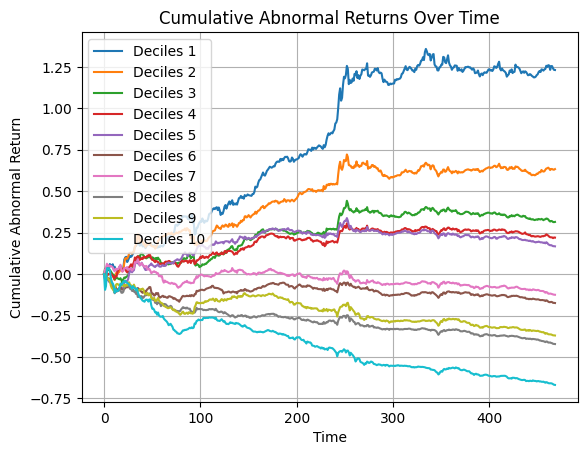

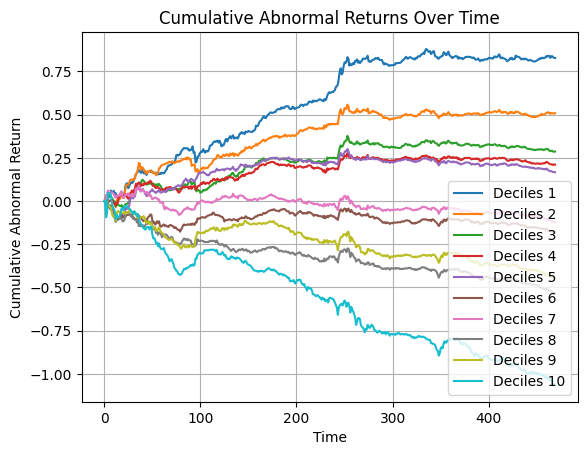

In [11]:
all_labels = np.expand_dims(data['data'][:, :, 0], axis=2) #all labels [time, funds]
for i in range (1, 11):
    exec(f'timestep_return_{i} = []') 
timesteps = 468
for i in range (0, timesteps):
    #sort funds based on model prediction
    timestep_pred = outputs[i,:,0] #take predictions of teh specific timestep
    timestep_label = all_labels[i,:,0] #take labels of the specific timestep 
    mask = get_valid_label_mask_month(timestep_label)
    timestep_pred_valid = timestep_pred[mask]
    timestep_label_valid = timestep_label[mask]
    fund_data = sort_fund(timestep_pred_valid.detach().numpy())
    for j in range (1, 11):
        decile_ind = select_decile(fund_data, j)
        decile = torch.tensor(timestep_label_valid)[decile_ind] #[funds, 1]
        decile_pred = torch.tensor(timestep_pred_valid)[decile_ind]
        return_month_equal = equal_weight(decile) #the weighted return for the month
        return_month_pred = prediction_weighted(decile, decile_pred, j)
        if return_month_equal.isnan():
            print("time", i)
        exec(f'timestep_return_{j}.append(return_month_pred)')
all_timestep_return = []
labels = []
for i in range (1, 11):
    exec(f'all_timestep_return.append(timestep_return_{i})')
    labels.append(f'Deciles {i}')
plot_returns(all_timestep_return, labels, cumulative=True)
plot_returns_sum(all_timestep_return, labels, cumulative=True)

In [12]:
#retrain loaded models 
#for the three folds:
#first, train/val on the second and third folds and test on the first
all_predictions_retrained =[]
for i in range (3):
    print(f'iteration {i+1}')
    print('------------------------------------------')
    #construct corresponding datasets
    all_folds = sampling_folds[i]
    test_idx = all_folds[2] #select the ith fold as the test set
    dataset_test = DS(data, test_idx)
    other_folds = [x for ind, x in enumerate(all_folds) if ind!=i]
    train_idx, val_idx = split_list_chronological(other_folds[0].tolist()+other_folds[1].tolist(), 0.75) #for other two folds, split into training and validation
    dataset_train = DS(data, train_idx)
    dataset_val = DS(data, val_idx)
    #dataset_train = DS(data, other_folds[0])
    #dataset_val = DS(data, other_folds[1])
    batch_size_train = len(dataset_train)
    batch_size_val = len(dataset_val)
    train_loader = DataLoader(dataset_train, shuffle=True, batch_size= batch_size_train)
    valid_loader = DataLoader(dataset_val, shuffle=False, batch_size = batch_size_val)
    checkdb(dataset_train, train_loader)
    #define and train model 
    model = model_list[i]
    train_model(model, 50, train_loader, valid_loader, learning_rate=0.001, early_stop=False)
    #predict with trained model 
    output = predict(model, sanitize_input_3d(data['data'][test_idx][:, :, indexes])) #output shape [time, funds, 1]
    all_predictions_retrained.append(output)

iteration 1
------------------------------------------
(25636,)
labels shape (25560, 1)
features shape (25560, 14)
(97845,)
labels shape (97764, 1)
features shape (97764, 14)
(13522,)
labels shape (13496, 1)
features shape (13496, 14)
Features shape: torch.Size([14])
Labels shape: torch.Size([1])
sample inputs: tensor([-0.2832, -0.0421, -0.0471, -0.1762,  0.2425,  0.1234,  0.1748, -0.4073,
         0.2832, -0.1961,  0.1969,  0.1063, -0.3024,  0.0300]) tensor([-1.9234])
loader Features shape: torch.Size([97764, 14])
loader Labels shape: torch.Size([97764, 1])
training start
----------------------
Epoch 1/50, Traning Loss: 2.4172050952911377, Validation loss: 3.6091270446777344
Epoch 2/50, Traning Loss: 2.417090892791748, Validation loss: 3.6092896461486816
Epoch 3/50, Traning Loss: 2.4169528484344482, Validation loss: 3.6094601154327393
Epoch 4/50, Traning Loss: 2.41682767868042, Validation loss: 3.6096420288085938
Epoch 5/50, Traning Loss: 2.4167118072509766, Validation loss: 3.6098227

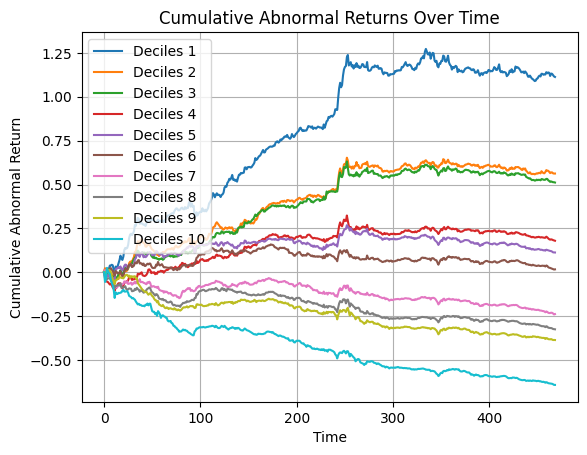

In [13]:
outputs = torch.cat(all_predictions_retrained, dim=0)
all_labels = np.expand_dims(data['data'][:, :, 0], axis=2) #all labels [time, funds]
for i in range (1, 11):
    exec(f'timestep_return_{i} = []') 
timesteps = 468
for i in range (0, timesteps):
    #sort funds based on model prediction
    timestep_pred = outputs[i,:,0] #take predictions of teh specific timestep
    timestep_label = all_labels[i,:,0] #take labels of the specific timestep 
    mask = get_valid_label_mask_month(timestep_label)
    timestep_pred_valid = timestep_pred[mask]
    timestep_label_valid = timestep_label[mask]
    fund_data = sort_fund(timestep_pred_valid.detach().numpy())
    for j in range (1, 11):
        decile_ind = select_decile(fund_data, j)
        decile = torch.tensor(timestep_label_valid)[decile_ind] #[funds, 1]
        #print('decile shape',decile.shape)
        #print("decile", decile)
        return_month = equal_weight(decile) #the weighted return for the month
        if return_month.isnan():
            print("time", i)
        exec(f'timestep_return_{j}.append(return_month)')
all_timestep_return = []
labels = []
for i in range (1, 11):
    exec(f'all_timestep_return.append(timestep_return_{i})')
    labels.append(f'Deciles {i}')
plot_returns(all_timestep_return, labels, cumulative=True)

In [31]:
path = '../mutualfund/Data and Code for Machine-Learning the Skill of Mutual Fund Managers/deep_learning/result_saved/chronological_order/output_all_order_465914.npz'
saveddata = np.load(path)
np.savetxt('target.txt',data['Rhat_all'])
saveddata['Rhat_all'].shape

(469, 3271)

In [37]:
#outputs = get_mean_elementwise(all_outputs)[:,:,0].detach().numpy()
#np.savetxt('actual.txt',outputs)
#outputs.shape
outputs = torch.tensor(np.expand_dims(saveddata['Rhat_all'],axis=2))
all_labels = np.expand_dims(data['data'][:, :, 0], axis=2)

/var/folders/by/qpw66qgj0ll1h0z_yglfwpfh0000gn/T/ipykernel_13263/855359724.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  decile_pred = torch.tensor(timestep_pred_valid)[decile_ind]
/var/folders/by/qpw66qgj0ll1h0z_yglfwpfh0000gn/T/ipykernel_13263/855359724.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  decile_pred = torch.tensor(timestep_pred_valid)[decile_ind]
/var/folders/by/qpw66qgj0ll1h0z_yglfwpfh0000gn/T/ipykernel_13263/855359724.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  decile_pred = torch.tensor(timestep_pred

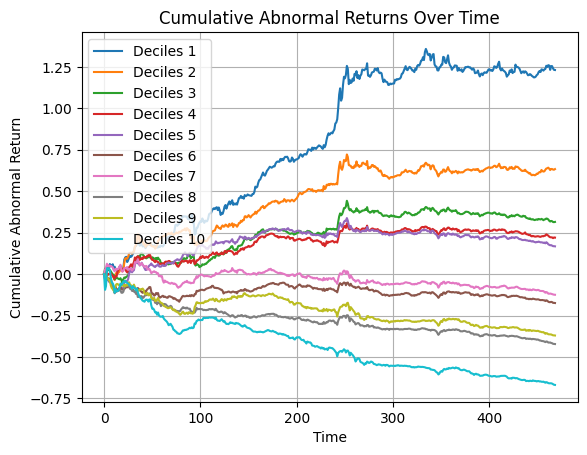

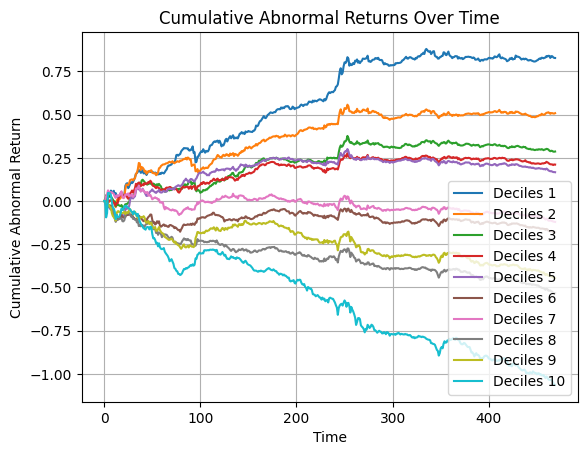

In [38]:
all_labels = np.expand_dims(data['data'][:, :, 0], axis=2) #all labels [time, funds]
for i in range (1, 11):
    exec(f'timestep_return_{i} = []') 
timesteps = 468
for i in range (0, timesteps):
    #sort funds based on model prediction
    timestep_pred = outputs[i,:,0] #take predictions of teh specific timestep
    timestep_label = all_labels[i,:,0] #take labels of the specific timestep 
    mask = get_valid_label_mask_month(timestep_label)
    timestep_pred_valid = timestep_pred[mask]
    timestep_label_valid = timestep_label[mask]
    fund_data = sort_fund(timestep_pred_valid.detach().numpy())
    for j in range (1, 11):
        decile_ind = select_decile(fund_data, j)
        decile = torch.tensor(timestep_label_valid)[decile_ind] #[funds, 1]
        decile_pred = torch.tensor(timestep_pred_valid)[decile_ind]
        return_month_equal = equal_weight(decile) #the weighted return for the month
        return_month_pred = prediction_weighted(decile, decile_pred, j)
        if return_month_equal.isnan():
            print("time", i)
        exec(f'timestep_return_{j}.append(return_month_pred)')
all_timestep_return = []
labels = []
for i in range (1, 11):
    exec(f'all_timestep_return.append(timestep_return_{i})')
    labels.append(f'Deciles {i}')
plot_returns(all_timestep_return, labels, cumulative=True)
plot_returns_sum(all_timestep_return, labels, cumulative=True)